In [41]:
import numpy as np
import pandas as pd
import os
import pickle
import xlsxwriter
from os.path import join as PT
import matplotlib.pyplot as plt

In [173]:
CODE = "32"
TREE_BASE_DIR = "Tree_Structure/"
SEGMENTS_BASE_DIR = "output_fixation/"+CODE+"/"+"freq_segment/data/"
#SEGMENTS_BASE_DIR = "output_fixation/"+CODE+"/logical_segments/freq_segment"
OUTPUT_DIR = "output_fixation/"+CODE+"/"+"tree_segment/"
#OUTPUT_DIR = "output_fixation/"+CODE+"/logical_segments/tree_segment"
VISUAL_DIR = "visual_plots/"
#VISUAL_DIR = "visual_logicalSegs/"
THRESHOLD = 0.05
color_map = {0 : "#dfe7f9", 1 : "#dae5d5", 2 : "#fff2cc", 3 : "#f8cecc", 4: "#e1d5e7", 5: "#e1d537", 6 : "#60a917",
            7 : "#0050ef", 8 : "#a20025"}
color_map_code = {0 : "#d80073", 1 : "#aa00ff", 2 : "#647687", 3 : "#6d8764", 4: "#fa6800", 5: "#e1d537", 6 : "#60a917",
            7 : "#0050ef", 8 : "#a20025"}
color_map = color_map_code

In [174]:
if not os.path.exists(os.path.join(OUTPUT_DIR)):
    os.mkdir(os.path.join(OUTPUT_DIR))
if not os.path.exists(os.path.join(TREE_BASE_DIR,CODE)):
    os.mkdir(os.path.join(TREE_BASE_DIR,CODE))
if not os.path.exists(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR)):
    os.mkdir(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR))

# Tree Data Generation

In [175]:
class Node:
    def __init__(self,name=None,node_num=0):
        self.node_num = node_num
        self.name = name
        self.children = []
        self.lines = []
        
    def insert(self,child):
        self.children.append(child)
    
    def traverse(self):
        print(self)
        for child in self.children:
            child.traverse()
    
    def __str__(self):
        return "["+str(self.node_num)+" : "+self.name+" : "+str(self.lines)\
    +" : "+str([x.node_num for x in self.children])+"]"

In [176]:
def read_and_create_tree(file):
    with open(file) as f:
        nodes = []
        for line in f:
            if line[-1] == '\n':
                line = line[:-1]
            statements = line.split(" ")
            if statements[0] == "CREATE":
                node = Node(statements[1],len(nodes))
                num_lines = int(statements[2])
                for i in range(num_lines):
                    node.lines.append(int(statements[i+3]))
                nodes.append(node)
            elif statements[0] == "INSERT":
                parent = int(statements[1])
                child = int(statements[2])
                nodes[parent].insert(nodes[child])
            else:
                print("Error: Invalid command!!")
                break
        return nodes[0]

In [177]:
def get_line_to_node_mapping(root,mappings):
    for line in root.lines:
        if line in mappings:
            print("Error : Line "+str(line)+" mapped twice")
            return
        mappings[line] = root
    for child in root.children:
        get_line_to_node_mapping(child,mappings)
    return

def init_node_counts(root,counts):
    counts[root] = 0
    for child in root.children:
        init_node_counts(child,counts)
        
def get_nodes(root,all_nodes):
    all_nodes[root.node_num] = root
    for child in root.children:
        get_nodes(child,all_nodes)
        
def get_major_components(data):
    major = []
    data = np.array(data)
    total = np.sum(data[:,1])
    for row in data:
        if row[1]/total >= THRESHOLD:
            major.append(row[0])
    return major

def update_node_counts(root,node_counts,major_lines,aggregate='min'):
    for child in root.children:
        update_node_counts(child,node_counts,major_lines)
    to_add = False
    for line in root.lines:
        if line in major_lines:
            to_add = True
            break
    if to_add:
        node_counts[root] = node_counts[root] + 1
    if len(root.lines) == 0:
        cts_child = []
        for child in root.children:
            cts_child.append(node_counts[child])
        cts_child = np.array(cts_child)
        if aggregate == 'min':
            func = np.min
        elif aggregate == 'max':
            func = np.max
        elif aggregate == 'sum':
            func = np.sum
        else:
            print("Error : Invalid aggregate!!")
            return
        node_counts[root] = func(cts_child)
        
def find_parents(root,prevNode,parents):
    parents[root] = prevNode
    for child in root.children:
        find_parents(child,root,parents)

def form_node_weights(root,line_weights,node_weights):
    if len(root.children) == 0:
        tot = 0
        for line in root.lines:
            tot += line_weights[line-1]
        node_weights[root] = (tot/len(root.lines),len(root.lines))
    else:
        tot = 0
        tot_lines = 0
        for child in root.children:
            form_node_weights(child,line_weights,node_weights)
            tot += node_weights[child][0]*node_weights[child][1]
            tot_lines += node_weights[child][1]
        node_weights[root] = (tot/tot_lines,tot_lines)        

In [178]:
root = read_and_create_tree(os.path.join(TREE_BASE_DIR,CODE,CODE+".tree"))
all_nodes = {}
get_nodes(root,all_nodes)
all_nodes

{0: <__main__.Node at 0x7fa26aa3fe10>,
 1: <__main__.Node at 0x7fa26aa3fda0>,
 2: <__main__.Node at 0x7fa26aa3f748>,
 3: <__main__.Node at 0x7fa26aa3fc88>,
 4: <__main__.Node at 0x7fa26aa3feb8>,
 5: <__main__.Node at 0x7fa26aa3fb38>,
 6: <__main__.Node at 0x7fa26aa3f780>,
 7: <__main__.Node at 0x7fa26aa3fd68>,
 8: <__main__.Node at 0x7fa26aa3fa90>,
 9: <__main__.Node at 0x7fa26aa3ff28>,
 10: <__main__.Node at 0x7fa26aa3f8d0>}

In [179]:
root.traverse()

[0 : root : [] : [1, 2]]
[1 : func-displayList : [] : [3, 4]]
[3 : statement : [3, 4, 5, 6] : []]
[4 : loop : [7, 8] : []]
[2 : func-main : [] : [5, 6]]
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []]
[6 : loop : [] : [7, 8]]
[7 : statement : [21, 22] : []]
[8 : loop : [] : [9, 10]]
[9 : statement : [23, 24] : []]
[10 : if : [25, 26, 27, 28, 29, 30] : []]


In [180]:
line_weights = []
with open(PT(TREE_BASE_DIR,CODE,CODE+"_complexity.txt")) as f:
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        line_weights.append(float(line))
line_weights

[0.5,
 0.5,
 0.5,
 0.5,
 1.0,
 0.5,
 2.0,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 2.0,
 0.5,
 2.0,
 1.0,
 1.0,
 2.0,
 0.5,
 2.0,
 0.5,
 2.0,
 0.5,
 2.0,
 0.5,
 1.0,
 1.0,
 1.0,
 0.5,
 0.5,
 0.5,
 2.0,
 1.0,
 0.5]

In [181]:
node_weights = {}
form_node_weights(root,line_weights,node_weights)
for k,v in node_weights.items():
    print(k,v)

[3 : statement : [3, 4, 5, 6] : []] (0.625, 4)
[4 : loop : [7, 8] : []] (1.25, 2)
[1 : func-displayList : [] : [3, 4]] (0.8333333333333334, 6)
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] (1.05, 10)
[7 : statement : [21, 22] : []] (1.25, 2)
[9 : statement : [23, 24] : []] (1.25, 2)
[10 : if : [25, 26, 27, 28, 29, 30] : []] (1.0, 6)
[8 : loop : [] : [9, 10]] (1.0625, 8)
[6 : loop : [] : [7, 8]] (1.1, 10)
[2 : func-main : [] : [5, 6]] (1.075, 20)
[0 : root : [] : [1, 2]] (1.0192307692307692, 26)


In [182]:
for file in os.listdir(os.path.join(SEGMENTS_BASE_DIR)):
    print(file)
    xls = pd.read_excel(os.path.join(SEGMENTS_BASE_DIR,file),sheetname=None)
    segment_status = []
    node_counts = {}
    init_node_counts(root,node_counts)
    for segment,data in xls.items():
        major_lines = get_major_components(data)
        print(major_lines)
        update_node_counts(root,node_counts,major_lines)
        segment_status.append(dict(node_counts))
    with open(os.path.join(OUTPUT_DIR,file[:-4]+"_segment_status.pkl"),'wb') as f:
        pickle.dump(segment_status,f)

final_matrix_newfix_vishal3.xlsx
[1, 2, 3, 5, 7, 13, 16]
[5, 6, 7, 9, 10, 12, 13, 15]
[18, 22, 24, 25]
[11, 14, 19]
final_matrix_newfix_shweta3.xlsx
[1, 2, 6, 7, 8, 10]
[13, 14, 16, 17, 18]
[22, 23, 24, 25]
[2, 3, 6, 7, 8]
[16, 17, 19, 20, 21, 22, 24, 29]
final_matrix_newfix_achal3.xlsx
[1, 2]
[14, 15, 16, 17, 19]
[3, 5, 6, 7, 8]
[13, 14, 15, 16, 23, 24, 25]
[13, 16, 17, 18, 19, 20, 21, 22, 25, 26, 28, 29]
[7, 10, 18, 20, 21, 22, 23, 24]
[18, 19, 20, 21, 23, 29, 30]
[17, 18, 19, 20, 21, 22]
[2, 8, 15, 17]
final_matrix_newfix_vrajesh3.xlsx
[4, 9, 10, 11, 19, 21]
[6, 7, 14, 15, 16, 17, 24, 25, 26, 28]
[7, 17, 18, 19, 21]
[9, 13, 14, 15]
[9, 30]
final_matrix_newfix_arihant3.xlsx
[2, 3, 5, 6, 7, 8]
[9, 12, 13, 14, 15, 16, 17]
[6, 7, 8]
[8, 17, 18, 22, 25]
[19, 20, 21, 22]
[17, 18, 19, 20, 21, 23]
[21, 22, 23, 24, 25, 30]
[6, 7, 13, 14, 15, 16, 19, 22]
[2, 3, 5, 8]
final_matrix_newfix_aditya3.xlsx
[1, 2, 3, 5, 6, 7, 8]
[13, 14, 16, 17, 22, 23, 24]
[6, 7, 8]
[13, 14, 15, 16]
[17, 18, 19, 24,

In [183]:
for node,ct in segment_status[5].items():
    print(node,ct)

[0 : root : [] : [1, 2]] 1
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 4
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 1
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 6
[6 : loop : [] : [7, 8]] 1
[7 : statement : [21, 22] : []] 2
[8 : loop : [] : [9, 10]] 1
[9 : statement : [23, 24] : []] 3
[10 : if : [25, 26, 27, 28, 29, 30] : []] 1


In [184]:
for file in os.listdir(os.path.join(OUTPUT_DIR)):
    print("Subject - ",file)
    with open(os.path.join(OUTPUT_DIR,file),'rb') as f:
        seg_stats = pickle.load(f)
    for i,seg_stat in enumerate(seg_stats):
        print("Segment : ",str(i+1))
        for node,ct in seg_stat.items():
            print(node,ct)
    print("==============================================================================")

Subject -  final_matrix_newfix_arihant3._segment_status.pkl
Segment :  1
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 0
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  2
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 1
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  3
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 2
[3 : statement : [3, 4, 5, 6] : []] 2
[4 : 

IsADirectoryError: [Errno 21] Is a directory: 'output_fixation/32/tree_segment/weighted'

# Tree Graph Generation

In [185]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [186]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
G = nx.Graph()

In [187]:
def read_and_create_graph(file):
    G = nx.DiGraph()
    terminal_nodes = []
    labels = {}
    with open(file) as f:
        ct = 0
        for line in f:
            if line[-1] == '\n':
                line = line[:-1]
            statements = line.split(" ")
            if statements[0] == "CREATE":
                label = statements[1]
                G.add_node(ct)                
                num_lines = int(statements[2])
                
                if num_lines != 0:
                    terminal_nodes.append(ct)
                    label += '\n'
                    label += statements[3]
                    label += " - "
                    label += statements[-1]
                    
                labels[ct] = label
                ct += 1
            elif statements[0] == "INSERT":
                parent = int(statements[1])
                child = int(statements[2])
                G.add_edge(parent,child)
                
                #nodes[parent].insert(nodes[child])
            else:
                print("Error: Invalid command!!")
                break
        return G, terminal_nodes, ct, labels

In [188]:
G, terminal_nodes, total_nodes, labels = read_and_create_graph(os.path.join(TREE_BASE_DIR,CODE,CODE+".tree"))
node_color = [('#dae5d5' if node in terminal_nodes else '#dfe7f9') for node in range(total_nodes)]

In [189]:
plt.figure(figsize=(20,15))
pos=graphviz_layout(G, prog='dot')
nx.draw(G,pos,arrows=False,node_size=20000,node_color=node_color,labels=labels,font_size=22)
plt.suptitle("Code %s Tree" % str(CODE),fontsize = 36)
plt.savefig(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,CODE+".png"))

/home/ayush/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [190]:
patches = []
num_colors = len(color_map)
for i in range(num_colors-1):
    pt = mpatches.Patch(color=color_map[i],label=str(i))
    patches.append(pt)
patches.append(mpatches.Patch(color=color_map[num_colors-1],label=str(num_colors-1)+"+"))

In [191]:
for file in os.listdir(os.path.join(OUTPUT_DIR)):
    sub_name = file[:-20]
    if not os.path.exists(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name)):
        os.mkdir(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name))
    print("Subject - ",sub_name)
    if os.path.isdir(PT(OUTPUT_DIR,file)):
        continue
    with open(os.path.join(OUTPUT_DIR,file),'rb') as f:
        seg_stats = pickle.load(f)
    for i,seg_stat in enumerate(seg_stats):
        seg_labels = dict(labels)
        for node, label in seg_labels.items():
            seg_labels[node] += "\n"
        segment_num = str(i+1)
        print("Segment : ",segment_num)
        for node,ct in seg_stat.items():
            node_num = node.node_num
            seg_labels[node_num] += "Count : " + str(ct)
            if ct in color_map:
                node_color[node_num] = color_map[ct]
            else:
                node_color[node_num] = color_map[len(color_map)-1]
            print(node,ct)
        plt.figure(figsize=(20,15))
        pos=graphviz_layout(G, prog='dot')
        nx.draw(G,pos,arrows=False,node_size=20000,node_color=node_color,labels=seg_labels,font_size=22)
        plt.suptitle("Segment %d" % (i+1),fontsize = 36)
        plt.legend(handles=patches,fontsize=24)
        plt.savefig(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name,segment_num+".png"))
    print("==============================================================================")

Subject -  final_matrix_newfix_arihant3
Segment :  1
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 0
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0


/home/ayush/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Segment :  2
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 1
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  3
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 2
[3 : statement : [3, 4, 5, 6] : []] 2
[4 : loop : [7, 8] : []] 2
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 1
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  4
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 2
[3 : statement : [3, 4, 5, 6] : []] 2
[4 : loop : [7, 8] : []] 3
[2 : func-main : [] : [5, 6]] 0
[5 : s

Segment :  3
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 1
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  4
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 2
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 1
[9 : statement : [23, 24] : []] 1
[10 : if : [25, 26, 27, 28, 29, 30] : []] 1
Segment :  5
[0 : root : [] : [1, 2]] 1
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 1
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 1
[5 : s

Segment :  3
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 3
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 3
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 0
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 0
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  4
[0 : root : [] : [1, 2]] 0
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 3
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 0
[5 : statement : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] : []] 4
[6 : loop : [] : [7, 8]] 0
[7 : statement : [21, 22] : []] 1
[8 : loop : [] : [9, 10]] 0
[9 : statement : [23, 24] : []] 1
[10 : if : [25, 26, 27, 28, 29, 30] : []] 0
Segment :  5
[0 : root : [] : [1, 2]] 1
[1 : func-displayList : [] : [3, 4]] 1
[3 : statement : [3, 4, 5, 6] : []] 3
[4 : loop : [7, 8] : []] 1
[2 : func-main : [] : [5, 6]] 1
[5 : s

## Coloring on Code

In [166]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [167]:
lines = []
with open(PT(TREE_BASE_DIR,CODE,"code"+CODE+".txt")) as f:
    for line in f:
        if line[-1]== '\n':
            line = line[:-1]
        lines.append(line)
lines

['/*C Program to Check whether two Strings are Anagrams */',
 '#include <stdio.h> ',
 'int main()',
 '{',
 '    char array1[100], array2[100];',
 '    int flag; ',
 '    printf("Enter the string\\n");',
 '    gets(array1);',
 '    printf("Enter another string\\n");',
 '    gets(array2);',
 '    flag = find_anagram(array1, array2);',
 '    if (flag == 1)',
 '        printf("%s and %s are anagrams.\\n", array1, array2);',
 '    else',
 '        printf("%s and %sare not anagrams.\\n", array1, array2);',
 '    return 0;',
 '} ',
 'int find_anagram(char array1[], char array2[])',
 '{',
 '    int num1[26] = {0}, num2[26] = {0}, i = 0; ',
 "    while (array1[i] != '\\0')",
 '    {',
 "        num1[array1[i] - 'a']++;",
 '        i++;',
 '    }',
 '    i = 0;',
 "    while (array2[i] == '\\0') //error  while (array2[i] != '\\0')",
 '    {',
 "        num2[array2[i] -'a']++;",
 '        i++;',
 '    }',
 '    for (i = 0; i < 26; i++)',
 '    {',
 '        if (num1[i] != num2[i])',
 '           

In [168]:
patches = []
num_colors = len(color_map_code)
for i in range(num_colors-1):
    pt = mpatches.Patch(color=color_map_code[i],label=str(i))
    patches.append(pt)
patches.append(mpatches.Patch(color=color_map_code[num_colors-1],label=str(num_colors-1)+"+"))
def last_text(num_lines,line_idx):
    req = num_lines - line_idx - 1
    ans = ""
    for i in range(req):
        ans += '\n'
    return ans

In [169]:
plt.figure(figsize=(20,15))
plt.axis('off')
for i, line in enumerate(lines):
    to_plot = line + last_text(len(lines),i)
    plt.text(0,0,to_plot,fontsize=24)
plt.suptitle("Code %s" % str(CODE),fontsize = 36)
plt.savefig(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,"code"+CODE+".png"),bbox_inches='tight')

/home/ayush/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [171]:
for file in os.listdir(os.path.join(OUTPUT_DIR)):
    plt.figure(figsize=(20,15))
    plt.axis('off')
    plotted = np.zeros(len(lines))
    sub_name = file[:-20]
    print("Subject - ",sub_name)
    if not os.path.exists(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name)):
        os.mkdir(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name))
    if not os.path.exists(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name,"codes")):
        os.mkdir(os.path.join(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name,"codes"))
    if os.path.isdir(PT(OUTPUT_DIR,file)):
        continue
    with open(os.path.join(OUTPUT_DIR,file),'rb') as f:
        seg_stats = pickle.load(f)
    for i ,seg_stat in enumerate(seg_stats):
        segment_num = str(i+1)
        print("Segment : ",segment_num)
        for node,ct in seg_stat.items():
            if len(node.children) != 0:
                continue
            node_num = node.node_num
            if ct in color_map_code:
                color = color_map_code[ct]
            else:
                color = color_map_code[len(color_map_code)-1]
            #print(node,ct)
            for line in node.lines:
                line_idx = line-1
                to_plot = lines[line_idx] + last_text(len(lines),line_idx)
                plt.text(0,0,to_plot,fontsize=24,color=color)
                plotted[line_idx] = 1
        for j, val in enumerate(plotted):
            if val == 0:
                to_plot = lines[j] + last_text(len(lines),j)
                plt.text(0,0,to_plot,fontsize=24)
        plt.legend(handles=patches,fontsize=24,loc=4)
        plt.suptitle("Segment %d" % (i+1),fontsize = 36)
        plt.savefig(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,sub_name,"codes",segment_num+".png"),bbox_inches='tight')

/home/ayush/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Subject -  final_matrix_newfix_rajdeep2
Subject -  final_matrix_newfix_ranajoy2
Subject -  final_matrix_newfix_Mayur2
Subject -  final_matrix_newfix_Rakesh_2
Subject -  final_matrix_newfix_asish2
Subject -  final_matrix_newfix_gari2
Subject -  
Subject -  final_matrix_newfix_anuraag2
Segment :  1
Segment :  2
Segment :  3
Segment :  4
Segment :  5
Segment :  6
Segment :  7
Segment :  8
Segment :  9
Segment :  10
Segment :  11
Segment :  12
Segment :  13
Segment :  14
Segment :  15
Segment :  16
Subject -  final_matrix_newfix_Vamsi2
Segment :  1
Segment :  2
Segment :  3
Segment :  4
Segment :  5
Segment :  6
Segment :  7
Segment :  8
Segment :  9
Segment :  10
Subject -  final_matrix_newfix_Sumanth_2
Segment :  1
Segment :  2
Segment :  3


## Segmentation based on Tree Structure

In [13]:
parents = {}
find_parents(root,None,parents)
for k,v in parents.items():
    print("Node : ",k.node_num, "Parent : ", (-1 if v is None else v.node_num))

Node :  0 Parent :  -1
Node :  1 Parent :  0
Node :  2 Parent :  0
Node :  4 Parent :  2
Node :  5 Parent :  2
Node :  9 Parent :  5
Node :  10 Parent :  5
Node :  12 Parent :  10
Node :  13 Parent :  10
Node :  16 Parent :  13
Node :  17 Parent :  13
Node :  14 Parent :  10
Node :  18 Parent :  14
Node :  19 Parent :  14
Node :  15 Parent :  10
Node :  11 Parent :  5
Node :  6 Parent :  2
Node :  3 Parent :  0
Node :  7 Parent :  3
Node :  8 Parent :  3


In [14]:
line_to_node = {}
get_line_to_node_mapping(root,line_to_node)

Error : Line 29 mapped twice


In [15]:
from filters import Filters
from frequency import Frequency
BASE_DIR = "fixationpoints/"+CODE+"/"
ALL_FILTERS = Filters(BASE_DIR)
FREQ = Frequency()
TARGET_DIR_SEG = "output_fixation/"+CODE+"/logical_segments/"
if not os.path.exists(TARGET_DIR_SEG):
    os.mkdir(TARGET_DIR_SEG)
if not os.path.exists(os.path.join(TARGET_DIR_SEG,"conservative")):
    os.mkdir(os.path.join(TARGET_DIR_SEG, "conservative"))
if not os.path.exists(os.path.join(TARGET_DIR_SEG,"freq_segment")):
    os.mkdir(os.path.join(TARGET_DIR_SEG, "freq_segment"))

In [16]:
for file in os.listdir(BASE_DIR):
    print(file)
    data = ALL_FILTERS.read_and_preprocess_data(file,-3)
    try:
        num_lines = int(np.max(data[:,0]))
    except IndexError as e:
        continue
    len_data = len(data)
    segments = []
    for i in range(1,len_data):
        prev = data[i-1][0]
        curr = data[i][0]
        if prev not in line_to_node or curr not in line_to_node:
            continue
        if prev == curr:
            continue
        node_prev = line_to_node[prev]
        node_curr = line_to_node[curr]
        if node_prev == node_curr or parents[node_prev] == parents[node_curr]:
            continue
        segments.append(data[i][1])
    
    seperated_segs = ALL_FILTERS.seperate_segments(data, segments)
    sheet = 0
    subfolder_data_seg = "freq_segment/"
    writer = pd.ExcelWriter(TARGET_DIR_SEG+subfolder_data_seg+file[:-5]+".xlsx",engine='xlsxwriter')
    for seg in seperated_segs:
        cts = FREQ.getFrequencies(seg,num_lines)
        df = pd.DataFrame(cts)
        sheet += 1
        df.to_excel(writer,sheet_name='Sheet{}'.format(sheet),header=["Line Number","Frequency"],index=False)
    writer.save()
    
    '''
    ALL_FILTERS.plot_colored_data_with_segments(data,np.array([]),segments,os.path.join(TARGET_DIR_SEG,file[:-4]+".png"))
    data = ALL_FILTERS.conservative_smoothing(data,5)
    len_data = len(data)
    segments_cons = []
    for i in range(1,len_data):
        prev = data[i-1][0]
        curr = data[i][0]
        if prev not in line_to_node or curr not in line_to_node:
            continue
        if prev == curr:
            continue
        node_prev = line_to_node[prev]
        node_curr = line_to_node[curr]
        if node_prev == node_curr or parents[node_prev] == parents[node_curr]:
            continue
        segments_cons.append(data[i][1])
    ALL_FILTERS.plot_colored_data_with_segments(data,np.array([]),segments,os.path.join(TARGET_DIR_SEG,"conservative",file[:-4]+".png"))
    
    '''

final_matrix_newfix_achal34.csv
final_matrix_newfix_Haque34.csv
final_matrix_newfix_anshul34.csv
final_matrix_newfix_sweta34.csv
final_matrix_newfix_archit34.csv


In [17]:
seperated_segs

[array([[    4,  3280],
        [    2,  3463],
        [    2,  3650],
        [    1,  3840],
        [    1,  4023],
        [    1,  4209],
        [    1,  4392],
        [    1,  4658],
        [    1,  4769],
        [    1,  4941],
        [    1,  5125],
        [    1,  5313],
        [    1,  5497],
        [    1,  5679],
        [    1,  5863],
        [    1,  6050],
        [    1,  6239],
        [    1,  6426],
        [    2,  6982],
        [    4,  7168],
        [    3,  7366],
        [    4,  7914],
        [    4,  8098],
        [    5,  8280],
        [    5,  8462],
        [    5,  8646],
        [    5,  8830],
        [    5,  9014],
        [    5,  9195],
        [    6,  9377],
        [    5,  9562],
        [    5,  9937],
        [    5, 10122],
        [    5, 10307],
        [    5, 10862],
        [    6, 11047],
        [    6, 11235],
        [    6, 11605],
        [    6, 11785],
        [    6, 11968],
        [    6, 12337],
        [    6, 

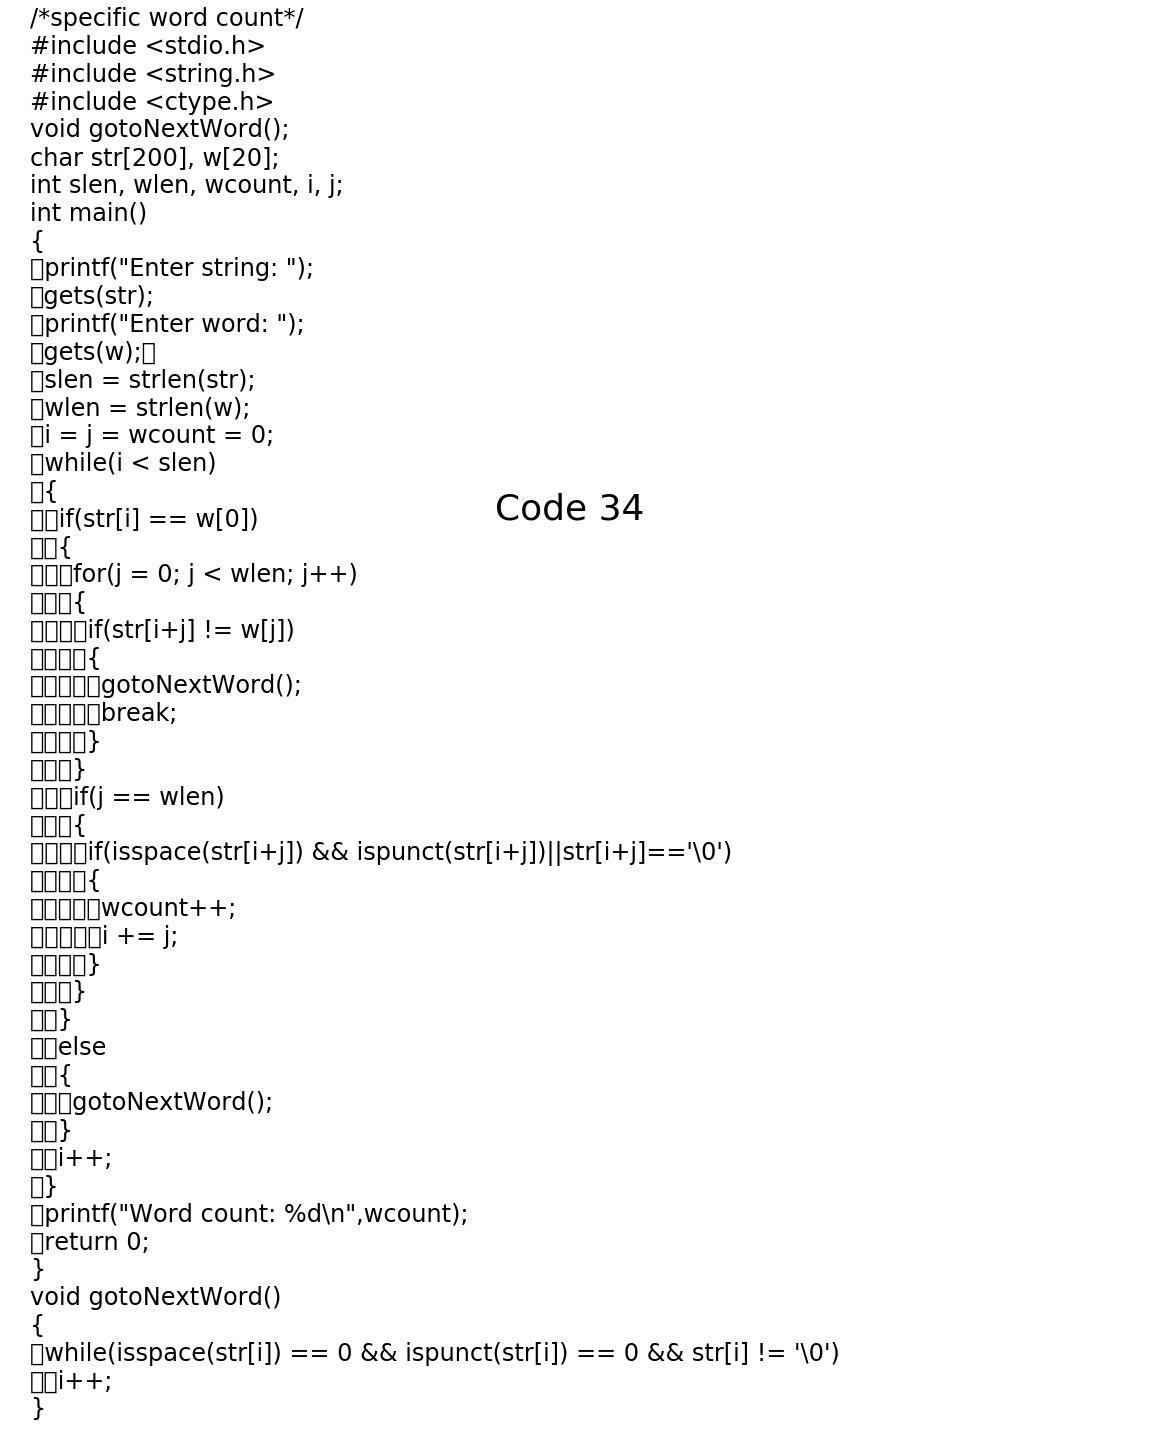

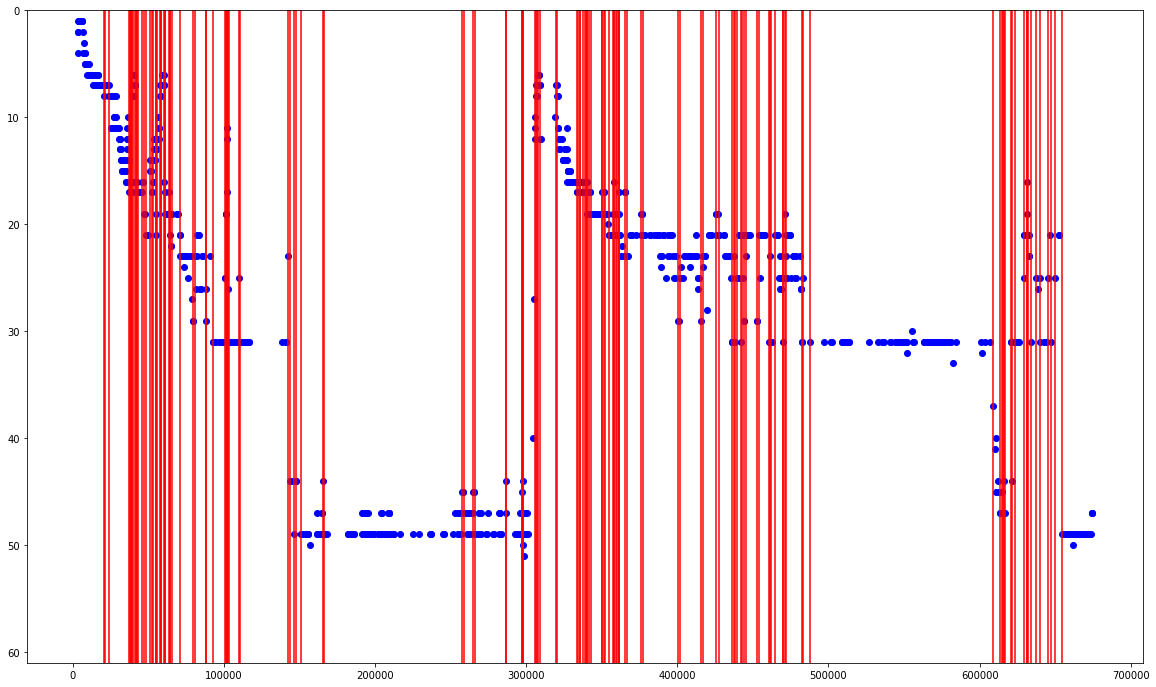

In [18]:
ALL_FILTERS.plot_colored_data_with_segments(data,np.array([]),segments)

In [19]:
ALL_FILTERS.plot_colored_data_with_segments(data,np.array([]),segments_cons)

NameError: name 'segments_cons' is not defined

In [59]:
line_to_node

{1: <__main__.Node at 0x7f9e008e6860>,
 2: <__main__.Node at 0x7f9e008e6860>,
 3: <__main__.Node at 0x7f9e008e6860>,
 4: <__main__.Node at 0x7f9e008e6550>,
 5: <__main__.Node at 0x7f9e008e6550>,
 6: <__main__.Node at 0x7f9e008e6550>,
 7: <__main__.Node at 0x7f9e008e6550>,
 8: <__main__.Node at 0x7f9e008e6438>,
 9: <__main__.Node at 0x7f9e008e6438>,
 10: <__main__.Node at 0x7f9e008e6438>,
 11: <__main__.Node at 0x7f9e008e6e10>,
 12: <__main__.Node at 0x7f9e008e6e10>,
 13: <__main__.Node at 0x7f9e008e6e10>,
 14: <__main__.Node at 0x7f9e008e6e10>,
 16: <__main__.Node at 0x7f9e008e6400>,
 17: <__main__.Node at 0x7f9e008e6400>,
 18: <__main__.Node at 0x7f9e008e6400>,
 19: <__main__.Node at 0x7f9e008e6400>}

# Merge

In [144]:
import cv2

In [192]:
all_files = os.listdir(PT(TREE_BASE_DIR,CODE,VISUAL_DIR))
for file in all_files:
    if not os.path.isdir(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file)):
        continue
    print(file)
    for myf in os.listdir(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file)):
        if os.path.isdir(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file,myf)):
            continue
        print(myf)
        imgs = []
        imgs.append(cv2.imread(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file,myf)))
        imgs.append(cv2.imread(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file,"codes",myf)))
        shapes = []
        shapes.append(imgs[0].shape)
        shapes.append(imgs[1].shape)
        print(shapes)
        to_add = abs(shapes[0][0] - shapes[1][0])
        append_in = 0
        if shapes[1][0] < shapes[0][0]:
            append_in = 1
        added_mat = np.zeros((to_add,shapes[append_in][1],shapes[append_in][2]),dtype=np.int64) + 255
        imgs[append_in] = np.concatenate([imgs[append_in],added_mat],axis=0)
        myim = np.concatenate(imgs,axis=1)
        if not os.path.exists(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file,"merged")):
            os.mkdir(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file,"merged"))
        cv2.imwrite(PT(TREE_BASE_DIR,CODE,VISUAL_DIR,file,"merged",myf),myim)

final_matrix_newfix_achal3
4.png
[(1080, 1440, 3), (995, 1161, 3)]
2.png
[(1080, 1440, 3), (995, 1161, 3)]
7.png
[(1080, 1440, 3), (995, 1161, 3)]
3.png
[(1080, 1440, 3), (995, 1161, 3)]
6.png
[(1080, 1440, 3), (995, 1161, 3)]
5.png
[(1080, 1440, 3), (995, 1161, 3)]
9.png
[(1080, 1440, 3), (995, 1161, 3)]
1.png
[(1080, 1440, 3), (995, 1161, 3)]
8.png
[(1080, 1440, 3), (995, 1161, 3)]
final_matrix_newfix_aditya3
4.png
[(1080, 1440, 3), (995, 1161, 3)]
2.png
[(1080, 1440, 3), (995, 1161, 3)]
7.png
[(1080, 1440, 3), (995, 1161, 3)]
3.png
[(1080, 1440, 3), (995, 1161, 3)]
6.png
[(1080, 1440, 3), (995, 1161, 3)]
5.png
[(1080, 1440, 3), (995, 1161, 3)]
1.png
[(1080, 1440, 3), (995, 1161, 3)]
final_matrix_newfix_anjali3
4.png
[(1080, 1440, 3), (995, 1161, 3)]
2.png
[(1080, 1440, 3), (995, 1161, 3)]
3.png
[(1080, 1440, 3), (995, 1161, 3)]
6.png
[(1080, 1440, 3), (995, 1161, 3)]
5.png
[(1080, 1440, 3), (995, 1161, 3)]
1.png
[(1080, 1440, 3), (995, 1161, 3)]
final_matrix_newfix_shweta3
4.png
[(1

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [19]:
img1.shape, img2.shape

((1080, 1440, 3), (954, 1161, 3))

In [33]:
to_add = abs(img1.shape[0] - img2.shape[0])
added_mat = np.zeros((to_add,img2.shape[1],img2.shape[2]),dtype=np.int64) + 255
img2new = np.concatenate([img2,added_mat],axis=0)

In [34]:
img2new.shape

(1080, 1161, 3)

In [40]:
myim = np.concatenate([img1,img2new],axis=1)
cv2.imwrite('waste.png',myim)

True

In [36]:
np.max(img1)

255

In [37]:
np.max(img2new)

255